# Gene-Peak Clusters

**Created**: 19 January 2022

## Environment

In [1]:
if (!requireNamespace("rtracklayer", quietly=T)) {
    install.packages("rtracklayer")
}

if (!requireNamespace("ComplexHeatmap", quietly=TRUE)) {
    BiocManager::install("ComplexHeatmap")
}

In [2]:
library(tidyverse)
library(RColorBrewer)
library(data.table)
library(rtracklayer)
library(ComplexHeatmap)

setwd("~/eQTL_pQTL_Characterization/")

source("03_Functional_Interpretation/scripts/utils/ggplot_theme.R")

── Attaching packages ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.7
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   2.1.1     ✔ forcats 0.5.1

── Conflicts ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following object is masked from ‘package:purrr’:

    transpose


Loading required package: GenomicRanges

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: parallel


Attachin

## Load Data

In [67]:
peaks <- fread("~/gains_team282/epigenetics/calderon_et_al/analysis/atac_seq/peak_counts.tsv", sep="\t")

In [68]:
head(peaks)

PeakID,Chr,Start,End,Strand,SRR7650729.filtered.sortedByName.bam,SRR7650730.filtered.sortedByName.bam,SRR7650731.filtered.sortedByName.bam,SRR7650732.filtered.sortedByName.bam,SRR7650733.filtered.sortedByName.bam,⋯,SRR7650915.filtered.sortedByName.bam,SRR7650916.filtered.sortedByName.bam,SRR7650917.filtered.sortedByName.bam,SRR7650918.filtered.sortedByName.bam,SRR7650919.filtered.sortedByName.bam,SRR7650920.filtered.sortedByName.bam,SRR7650921.filtered.sortedByName.bam,SRR7650922.filtered.sortedByName.bam,SRR7650923.filtered.sortedByName.bam,SRR7650924.filtered.sortedByName.bam
<chr>,<chr>,<int>,<int>,<chr>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1:23224-23849,1,23224,23849,+,30,60,33,36,20,⋯,22,36,42,50,22,36,38,36,34,17
1:24025-26778,1,24025,26778,+,133,153,170,162,93,⋯,182,174,190,281,180,184,204,211,166,73
1:28524-30136,1,28524,30136,+,1529,1820,1704,1286,1794,⋯,556,261,520,676,368,608,444,318,282,199
1:30354-30875,1,30354,30875,+,21,32,32,24,8,⋯,32,29,40,74,19,52,23,51,31,18
1:31109-31894,1,31109,31894,+,39,36,28,51,15,⋯,55,94,63,97,57,73,47,48,53,40
1:32151-32330,1,32151,32330,+,13,9,18,6,9,⋯,13,18,17,8,13,19,15,20,9,11


In [69]:
peaks.info <- peaks[,1:5] %>%
    dplyr::select(PeakID, Peak.Chr=Chr, Peak.Start=Start, Peak.End=End)

head(peaks.info)

PeakID,Peak.Chr,Peak.Start,Peak.End
<chr>,<chr>,<int>,<int>
1:23224-23849,1,23224,23849
1:24025-26778,1,24025,26778
1:28524-30136,1,28524,30136
1:30354-30875,1,30354,30875
1:31109-31894,1,31109,31894
1:32151-32330,1,32151,32330


In [70]:
peaks <- as.data.frame(peaks)
peaks <- peaks[,-(1:5)]
colnames(peaks) <- sapply(strsplit(colnames(peaks), "\\."), function(x) { x[1] })
rownames(peaks) <- peaks.info$PeakID

In [71]:
head(peaks)

,SRR7650729,SRR7650730,SRR7650731,SRR7650732,SRR7650733,SRR7650734,SRR7650735,SRR7650736,SRR7650737,SRR7650738,⋯,SRR7650915,SRR7650916,SRR7650917,SRR7650918,SRR7650919,SRR7650920,SRR7650921,SRR7650922,SRR7650923,SRR7650924
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1:23224-23849,30,60,33,36,20,24,63,48,36,29,⋯,22,36,42,50,22,36,38,36,34,17
1:24025-26778,133,153,170,162,93,147,256,144,150,120,⋯,182,174,190,281,180,184,204,211,166,73
1:28524-30136,1529,1820,1704,1286,1794,2116,1468,1450,1109,2177,⋯,556,261,520,676,368,608,444,318,282,199
1:30354-30875,21,32,32,24,8,20,28,34,29,17,⋯,32,29,40,74,19,52,23,51,31,18
1:31109-31894,39,36,28,51,15,41,82,47,33,34,⋯,55,94,63,97,57,73,47,48,53,40
1:32151-32330,13,9,18,6,9,11,10,12,11,10,⋯,13,18,17,8,13,19,15,20,9,11


In [18]:
atac.seq.metadata <- read.csv("03_Functional_Interpretation/metadata/reads_calderon_et_al_atac_seq.txt")

In [19]:
head(atac.seq.metadata)

,Run,Assay.Type,AvgSpotLen,Bases,BioProject,BioSample,Bytes,Cell_type,Center.Name,Consent,⋯,LibrarySelection,LibrarySource,lineage,Organism,Platform,ReleaseDate,Sample.Name,source_name,SRA.Study,treatment
,<chr>,<chr>,<int>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,SRR7650729,ATAC-seq,130,7671684082,PRJNA484801,SAMN09769836,3235449960,Bulk_B,GEO,public,⋯,other,GENOMIC,B,Homo sapiens,ILLUMINA,2018-09-06T00:00:00Z,GSM3320229,primary blood,SRP156496,no_treament
2,SRR7650730,ATAC-seq,130,8755083677,PRJNA484801,SAMN09769835,3691300841,Bulk_B,GEO,public,⋯,other,GENOMIC,B,Homo sapiens,ILLUMINA,2018-09-06T00:00:00Z,GSM3320230,primary blood,SRP156496,treatment1
3,SRR7650731,ATAC-seq,131,8483939942,PRJNA484801,SAMN09769834,3602660374,Mem_B,GEO,public,⋯,other,GENOMIC,B,Homo sapiens,ILLUMINA,2018-09-06T00:00:00Z,GSM3320231,primary blood,SRP156496,no_treament
4,SRR7650733,ATAC-seq,132,7063118195,PRJNA484801,SAMN09769832,3012041722,Naive_B,GEO,public,⋯,other,GENOMIC,B,Homo sapiens,ILLUMINA,2018-09-06T00:00:00Z,GSM3320233,primary blood,SRP156496,no_treament
5,SRR7650735,ATAC-seq,130,8705610661,PRJNA484801,SAMN09769830,3659122131,Plasmablasts,GEO,public,⋯,other,GENOMIC,B,Homo sapiens,ILLUMINA,2018-09-06T00:00:00Z,GSM3320235,primary blood,SRP156496,no_treament
6,SRR7650736,ATAC-seq,132,8457505958,PRJNA484801,SAMN09769829,3669541907,CD8pos_T,GEO,public,⋯,other,GENOMIC,CD8,Homo sapiens,ILLUMINA,2018-09-06T00:00:00Z,GSM3320236,primary blood,SRP156496,no_treament


In [20]:
genes <- read.csv("~/gains_team282/epigenetics/calderon_et_al/analysis/rna_seq/counts_normalized.csv", row.names=1, stringsAsFactors=F)

In [21]:
head(genes)

,SRR11007187,SRR11007186,SRR7647733,SRR11007183,SRR11007177,SRR11007062,SRR7647801,SRR7647731,SRR11007089,SRR11007061,⋯,SRR11007105,SRR11007169,SRR11007182,SRR7647655,SRR11007094,SRR7647697,SRR11007106,SRR7647660,SRR7647768,SRR11007097
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSG00000223972,-4.373643,-4.9524289,-4.698456,-5.8748841,-5.689776,-7.221049,-4.344822,-3.579351,-6.719863,-6.040948,⋯,-6.093293,-5.567996,-5.0025744,-5.928265,-2.870949,-5.265528,-5.834175,-3.114331,-4.171178,-3.837762
ENSG00000227232,-4.597347,-0.7838148,-3.808940,-0.2159444,-5.913479,-3.861321,-3.702782,-2.689835,-4.424265,-3.504342,⋯,-2.915984,-3.469771,0.1999871,-2.337211,-2.318576,-1.701197,-1.602419,-1.956236,-2.809919,-4.360893
ENSG00000240361,-4.115854,-4.6946401,-4.684772,-5.6170953,-5.431987,-4.225502,-4.374263,-1.980705,-6.531671,-5.852756,⋯,-5.897970,-5.310207,-4.7447855,-5.740073,-2.320187,-5.070206,-5.638853,-2.926139,-3.913390,-3.642439
ENSG00000238009,-4.471617,-5.0504023,-4.815500,-4.3878950,-5.787749,-7.659453,-3.848383,-3.696395,-7.158266,-6.479352,⋯,-2.903252,-5.665969,-5.1005477,-4.781706,-1.724390,-2.923484,-5.814059,-3.552734,-4.269152,-3.817646
ENSG00000233750,-4.311496,-4.8902815,-4.867449,-5.8127367,-5.627628,-7.442411,-2.275005,-3.748344,-6.941225,-6.262310,⋯,-3.733449,-5.505848,-4.9404269,-4.564664,-3.577738,-5.227613,-5.796260,-3.335693,-4.109031,-3.799846
ENSG00000268903,-4.708663,-5.2874484,-4.940078,-6.2099036,-6.024795,-5.727305,-1.905618,-1.013619,-5.226119,-1.288470,⋯,-6.261876,-5.903015,-5.3375938,-4.071951,-2.904452,-5.434112,-6.002759,-4.427942,-4.506198,-4.006345


In [22]:
genes.info <- import("/lustre/scratch118/humgen/resources/rna_seq_genomes/Homo_sapiens.GRCh38.99.gtf")

In [23]:
genes.info <- as.data.frame(genes.info) %>%
    dplyr::filter(gene_id %in% rownames(genes)) %>%
    dplyr::filter(type == "gene") %>%
    dplyr::select(Gene.ID=gene_id, Chr=seqnames, Start=start, End=end, Width=width, Strand=strand, Gene.Name=gene_name, Gene.Biotype=gene_biotype)

head(genes.info)

,Gene.ID,Chr,Start,End,Width,Strand,Gene.Name,Gene.Biotype
,<chr>,<fct>,<int>,<int>,<int>,<fct>,<chr>,<chr>
1,ENSG00000223972,1,11869,14409,2541,+,DDX11L1,transcribed_unprocessed_pseudogene
2,ENSG00000227232,1,14404,29570,15167,-,WASH7P,unprocessed_pseudogene
3,ENSG00000240361,1,57598,64116,6519,+,OR4G11P,transcribed_unprocessed_pseudogene
4,ENSG00000238009,1,89295,133723,44429,-,AL627309.1,lncRNA
5,ENSG00000233750,1,131025,134836,3812,+,CICP27,processed_pseudogene
6,ENSG00000268903,1,135141,135895,755,-,AL627309.6,processed_pseudogene


In [24]:
rna.seq.metadata <- read.csv("03_Functional_Interpretation/metadata/reads_calderon_et_al_rna_seq.txt")

In [25]:
head(rna.seq.metadata)

,Run,Assay.Type,AvgSpotLen,Bases,BioProject,BioSample,Bytes,Cell_type,Center.Name,Consent,⋯,LibrarySelection,LibrarySource,lineage,Organism,Platform,ReleaseDate,Sample.Name,source_name,SRA.Study,treatment
,<chr>,<chr>,<int>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,SRR11007061,RNA-Seq,192,8160479782,PRJNA484735,SAMN09768434,2579781267,CD8pos_T,GEO,public,⋯,cDNA,TRANSCRIPTOMIC,CD8,Homo sapiens,ILLUMINA,2020-02-04T00:00:00Z,GSM3319750,primary blood,SRP156452,no_treament
2,SRR11007062,RNA-Seq,195,15315982752,PRJNA484735,SAMN09768433,4836924733,CD8pos_T,GEO,public,⋯,cDNA,TRANSCRIPTOMIC,CD8,Homo sapiens,ILLUMINA,2020-02-04T00:00:00Z,GSM3319751,primary blood,SRP156452,treatment1
3,SRR11007063,RNA-Seq,195,13128598440,PRJNA484735,SAMN09768432,4155236675,Central_memory_CD8pos_T,GEO,public,⋯,cDNA,TRANSCRIPTOMIC,CD8,Homo sapiens,ILLUMINA,2020-02-04T00:00:00Z,GSM3319752,primary blood,SRP156452,no_treament
4,SRR11007064,RNA-Seq,193,4866405615,PRJNA484735,SAMN09768431,1546902050,Central_memory_CD8pos_T,GEO,public,⋯,cDNA,TRANSCRIPTOMIC,CD8,Homo sapiens,ILLUMINA,2020-02-04T00:00:00Z,GSM3319753,primary blood,SRP156452,treatment1
5,SRR11007065,RNA-Seq,195,9601276948,PRJNA484735,SAMN09768430,3023735003,Effector_memory_CD8pos_T,GEO,public,⋯,cDNA,TRANSCRIPTOMIC,CD8,Homo sapiens,ILLUMINA,2020-02-04T00:00:00Z,GSM3319754,primary blood,SRP156452,no_treament
6,SRR11007066,RNA-Seq,196,9273440229,PRJNA484735,SAMN09768429,2953466798,Effector_memory_CD8pos_T,GEO,public,⋯,cDNA,TRANSCRIPTOMIC,CD8,Homo sapiens,ILLUMINA,2020-02-04T00:00:00Z,GSM3319755,primary blood,SRP156452,treatment1


## Find Overlapping Samples

A sample is uniquely identified given the donor, cell type, and treatment. I will use this to map runs between the two data modalities.

In [35]:
sample.map <- merge(
    atac.seq.metadata %>%
        dplyr::mutate(Treatment=plyr::revalue(treatment, c("no_treament"="No_Treatment", "treatment1"="Treatment_1", "treatment2"="Treatment_2"))) %>%
        dplyr::mutate(ID=paste0(Donor, ":", Cell_type, ":", Treatment)) %>%
        dplyr::select(ID, ATAC.Seq.ID=Run),
    rna.seq.metadata %>%
        dplyr::mutate(Treatment=plyr::revalue(treatment, c("no_treament"="No_Treatment", "treatment1"="Treatment_1", "treatment2"="Treatment_2"))) %>%
        dplyr::mutate(ID=paste0(Donor, ":", Cell_type, ":", Treatment)) %>%
        dplyr::select(ID, RNA.Seq.ID=Run),
    by="ID"
) %>%
    dplyr::filter(ATAC.Seq.ID %in% colnames(peaks)) %>%
    dplyr::filter(RNA.Seq.ID %in% colnames(genes))

Reorder peak counts and gene counts by sample map so that the matrices are directly comparable.

In [36]:
head(sample.map)

,ID,ATAC.Seq.ID,RNA.Seq.ID
,<chr>,<chr>,<chr>
1,1001:Mature_NK:No_Treatment,SRR7650764,SRR11007090
2,1001:Mature_NK:Treatment_1,SRR7650765,SRR11007091
3,1001:Memory_Teffs:No_Treatment,SRR7650749,SRR11007075
4,1001:Memory_Teffs:Treatment_1,SRR7650750,SRR11007076
5,1001:Memory_Tregs:No_Treatment,SRR7650751,SRR11007077
6,1001:Memory_Tregs:Treatment_1,SRR7650752,SRR11007078


In [72]:
peaks <- peaks[, sample.map$ATAC.Seq.ID]
colnames(peaks) <- sample.map$ID

In [38]:
genes <- genes[, sample.map$RNA.Seq.ID]
colnames(genes) <- sample.map$ID

## Peaks near Gene TSS

We define the *cis* region to be the 1 Mb region flanking the transcription start site (TSS) of a gene. I will identify peaks that are in the 1 Mb region around each gene.

In [101]:
peaks.ranges <- peaks.info %>%
    dplyr::filter(Peak.Chr %in% genes.info$Chr) %>%
    makeGRangesFromDataFrame(
        df=.,
        seqnames.field="Peak.Chr",
        start.field="Peak.Start",
        end.field="Peak.End",
        keep.extra.columns=TRUE
    )

In [108]:
cis.ranges <- genes.info %>%
    dplyr::filter(Chr %in% peaks.info$Peak.Chr) %>%
    dplyr::mutate(TSS=ifelse(Strand == "+", Start, End)) %>%
    dplyr::mutate(Cis.Start=TSS - (10^6 - 1)) %>%
    dplyr::mutate(Cis.Start=ifelse(Cis.Start < 1, 1, Cis.Start)) %>%
    dplyr::mutate(Cis.End=TSS + (10^6)) %>%
    dplyr::mutate(Cis.End=ifelse(Cis.End < 1, 1, Cis.End)) %>%
    makeGRangesFromDataFrame(
        df=.,
        seqnames.field="Chr",
        start.field="Cis.Start",
        end.field="Cis.End",
        keep.extra.columns=TRUE
    )

In [109]:
cis.eqtl <- readRDS("~/gains_team282/eqtl/cisresults/cisqtl_all_significant.rds")

In [110]:
gene.idx <- which(cis.ranges$Gene.Name == "HIF1A")
gene.id <- mcols(cis.ranges[gene.idx,])[,"Gene.ID"]

In [111]:
overlaps <- findOverlaps(cis.ranges, peaks.ranges) %>%
    as.data.frame() %>%
    dplyr::filter(queryHits == gene.idx)

In [112]:
sample.map$ID

[1] "1001:Mature_NK:No_Treatment"               
  [2] "1001:Mature_NK:Treatment_1"                
  [3] "1001:Memory_Teffs:No_Treatment"            
  [4] "1001:Memory_Teffs:Treatment_1"             
  [5] "1001:Memory_Tregs:No_Treatment"            
  [6] "1001:Memory_Tregs:Treatment_1"             
  [7] "1001:Monocytes:No_Treatment"               
  [8] "1001:Monocytes:Treatment_1"                
  [9] "1001:Myeloid_DCs:No_Treatment"             
 [10] "1001:Naive_Teffs:No_Treatment"             
 [11] "1001:Naive_Teffs:Treatment_1"              
 [12] "1001:pDCs:No_Treatment"                    
 [13] "1001:Regulatory_T:No_Treatment"            
 [14] "1001:Regulatory_T:Treatment_1"             
 [15] "1001:Th1_precursors:No_Treatment"          
 [16] "1001:Th1_precursors:Treatment_1"           
 [17] "1001:Th17_precursors:No_Treatment"         
 [18] "1001:Th17_precursors:Treatment_1"          
 [19] "1001:Th2_precursors:No_Treatment"          
 [20] "1001:Th2_precursors:Treatment_1"           
 [21] "1002:Bulk_B:No_Treatment"                  
 [22] "1002:Bulk_B:Treatment_1"                   
 [23] "1002:CD8pos_T:No_Treatment"                
 [24] "1002:CD8pos_T:Treatment_1"                 
 [25] "1002:Central_memory_CD8pos_T:Treatment_1"  
 [26] "1002:Effector_CD4pos_T:Treatment_1"        
 [27] "1002:Effector_memory_CD8pos_T:No_Treatment"
 [28] "1002:Effector_memory_CD8pos_T:Treatment_1" 
 [29] "1002:Follicular_T_Helper:No_Treatment"     
 [30] "1002:Follicular_T_Helper:Treatment_1"      
 [31] "1002:Gamma_delta_T:No_Treatment"           
 [32] "1002:Mature_NK:Treatment_1"                
 [33] "1002:Mem_B:No_Treatment"                   
 [34] "1002:Mem_B:Treatment_1"                    
 [35] "1002:Memory_NK:No_Treatment"               
 [36] "1002:Memory_Teffs:No_Treatment"            
 [37] "1002:Memory_Teffs:Treatment_1"             
 [38] "1002:Memory_Tregs:Treatment_1"             
 [39] "1002:Monocytes:Treatment_1"                
 [40] "1002:Myeloid_DCs:No_Treatment"             
 [41] "1002:Naive_B:No_Treatment"                 
 [42] "1002:Naive_CD8_T:No_Treatment"             
 [43] "1002:Naive_CD8_T:Treatment_1"              
 [44] "1002:Naive_Teffs:No_Treatment"             
 [45] "1002:Naive_Teffs:Treatment_1"              
 [46] "1002:Regulatory_T:No_Treatment"            
 [47] "1002:Regulatory_T:Treatment_1"             
 [48] "1002:Th1_precursors:No_Treatment"          
 [49] "1002:Th1_precursors:Treatment_1"           
 [50] "1002:Th17_precursors:No_Treatment"         
 [51] "1002:Th17_precursors:Treatment_1"          
 [52] "1002:Th2_precursors:No_Treatment"          
 [53] "1002:Th2_precursors:Treatment_1"           
 [54] "1003:Bulk_B:No_Treatment"                  
 [55] "1003:Bulk_B:Treatment_1"                   
 [56] "1003:CD8pos_T:No_Treatment"                
 [57] "1003:CD8pos_T:Treatment_1"                 
 [58] "1003:Central_memory_CD8pos_T:No_Treatment" 
 [59] "1003:Central_memory_CD8pos_T:Treatment_1"  
 [60] "1003:Effector_CD4pos_T:Treatment_1"        
 [61] "1003:Effector_memory_CD8pos_T:No_Treatment"
 [62] "1003:Effector_memory_CD8pos_T:Treatment_1" 
 [63] "1003:Follicular_T_Helper:No_Treatment"     
 [64] "1003:Follicular_T_Helper:Treatment_1"      
 [65] "1003:Gamma_delta_T:No_Treatment"           
 [66] "1003:Gamma_delta_T:Treatment_1"            
 [67] "1003:Mature_NK:No_Treatment"               
 [68] "1003:Mature_NK:Treatment_1"                
 [69] "1003:Mem_B:Treatment_1"                    
 [70] "1003:Memory_Teffs:No_Treatment"            
 [71] "1003:Memory_Teffs:Treatment_1"             
 [72] "1003:Memory_Tregs:No_Treatment"            
 [73] "1003:Memory_Tregs:Treatment_1"             
 [74] "1003:Monocytes:No_Treatment"               
 [75] "1003:Monocytes:Treatment_1"                
 [76] "1003:Naive_B:Treatment_1"                  
 [77] "1003:Naive_CD8_T:No_Treatment"             
 [78] "1003:Naive_CD8_T:Treatment_1"              
 [79] "1003:Naive_Teffs:

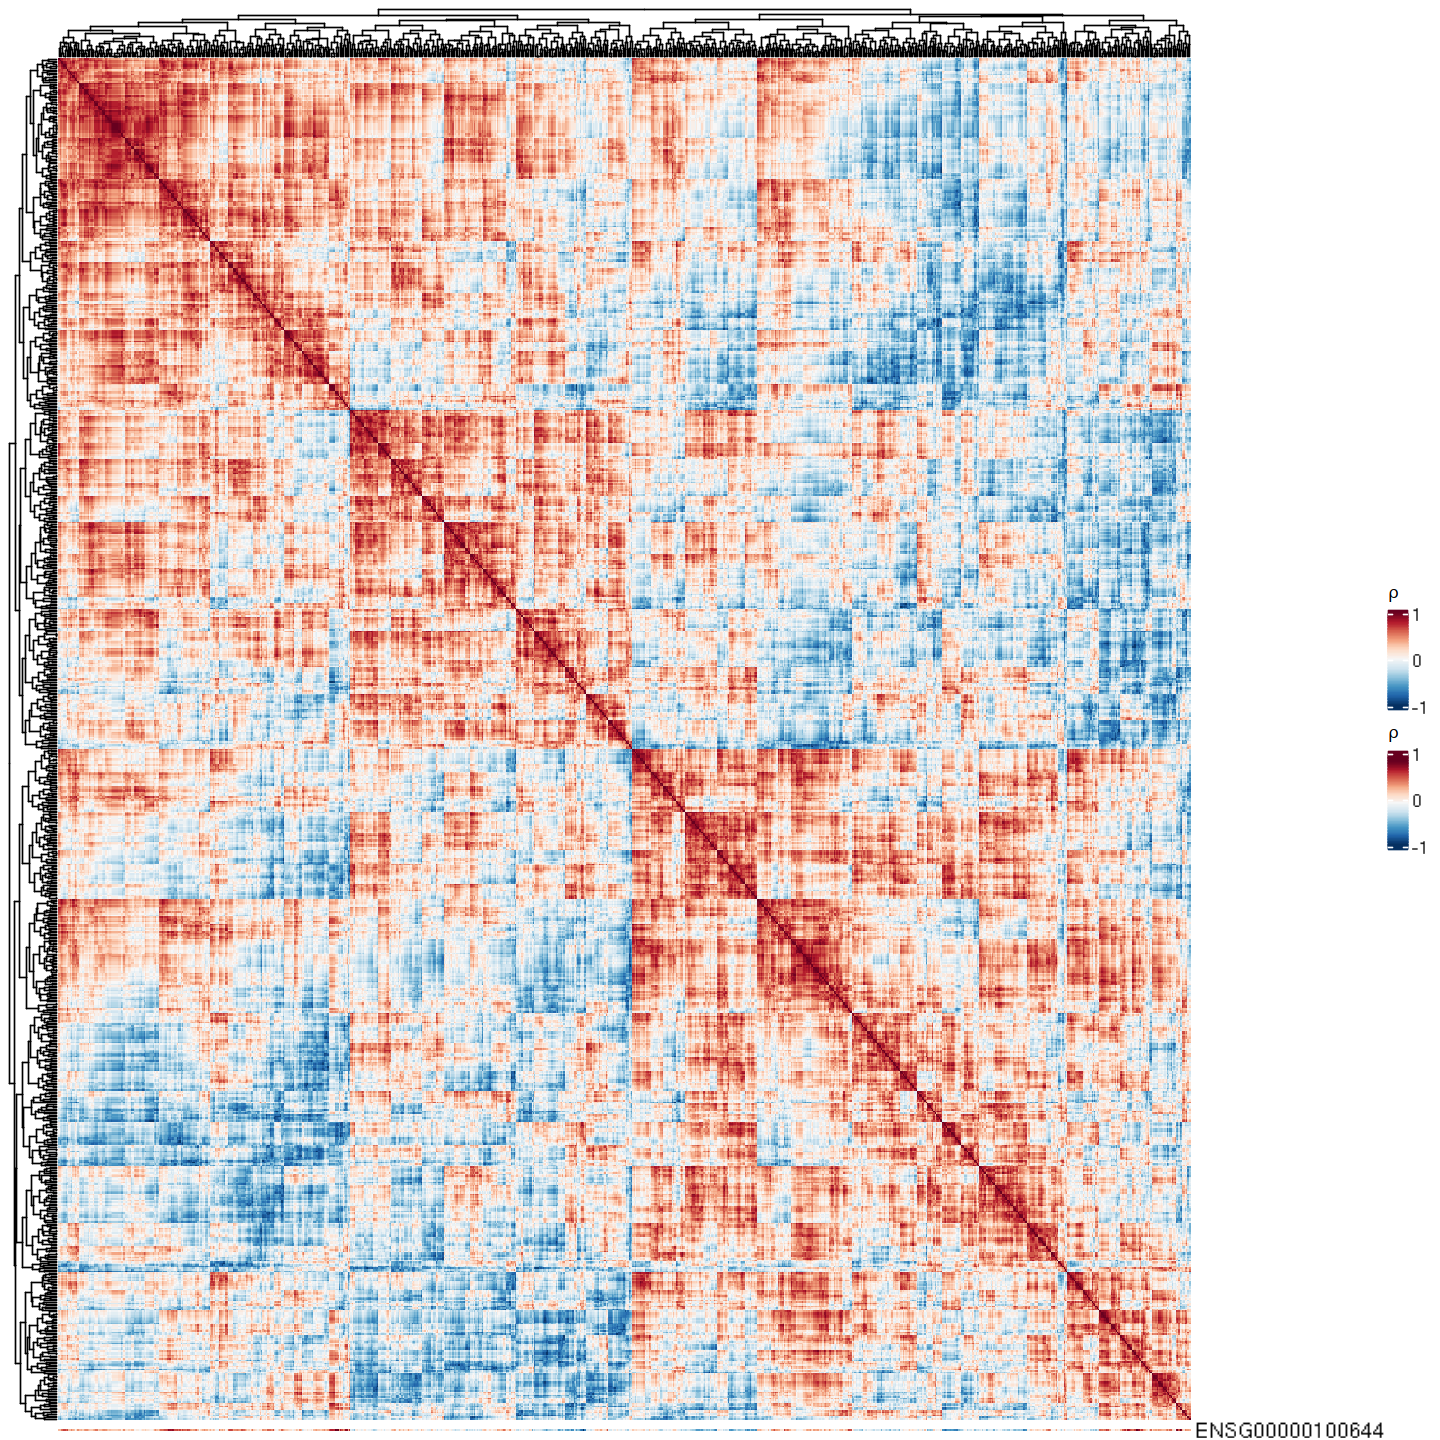

In [115]:
peak.ids <- mcols(peaks.ranges[overlaps$subjectHits,])[,"PeakID"]

cor.mtx.all <- cor(t(rbind(
    peaks[peak.ids, sample.map$ID[grepl("Regulatory_T", sample.map$ID)]],
    genes[gene.idx, sample.map$ID[grepl("Regulatory_T", sample.map$ID)]]
)), method="kendall")

cor.mtx <- cor.mtx.all[peak.ids, peak.ids]
cor.mtx.gene <- cor.mtx.all[gene.id, peak.ids, drop=F]

options(repr.plot.width=12, repr.plot.height=12)

colors <- colorRampPalette(rev(brewer.pal(11, "RdBu")))(101)
h1 <- Heatmap(cor.mtx, col=colors, show_column_names=F, show_row_names=F, heatmap_legend_param=list(
    title=bquote(rho), at=c(-1, 0, 1)
))
h2 <- Heatmap(cor.mtx.gene, col=colors, show_column_names=F, heatmap_legend_param=list(
    title=bquote(rho), at=c(-1, 0, 1)
))
h1 %v% h2

In [105]:
cis.eqtl %>%
    dplyr::filter(chr==14) %>%
    dplyr::filter(SNPpos >= 22847665) %>%
    dplyr::filter(SNPpos <= 22850275)

snps,gene,statistic,pvalue,beta,se,chr,SNPpos,TSS,threshold
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<dbl>


In [88]:
da.peaks <- read.csv("~/gains_team282/epigenetics/calderon_et_al/analysis/atac_seq/da_peak_set.csv", row.names=1)

In [60]:
da.peaks %>%
    dplyr::filter(Cell.Type=="Monocytes") %>%
    dplyr::arrange(desc(abs(logFC)))

Contrast,Cell.Type,Peak.ID,Peak.Chr,Peak.Start,Peak.End,logFC,AveExpr,t,P.Value,adj.P.Val,B
<chr>,<chr>,<chr>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Monocytes_Stimulated-Monocytes_Baseline,Monocytes,14:22850378-22852159,14,22850378,22852159,2.245294,1.8136113,6.872552,1.886279e-10,7.002811e-06,12.225601
Monocytes_Stimulated-Monocytes_Baseline,Monocytes,12:24718000-24720180,12,24718000,24720180,2.213399,2.0312811,5.347850,3.517275e-07,2.176314e-03,5.837434
Monocytes_Stimulated-Monocytes_Baseline,Monocytes,6:161127967-161130430,6,161127967,161130430,1.793257,2.2065711,5.258303,5.293406e-07,2.456471e-03,5.490682
Monocytes_Stimulated-Monocytes_Baseline,Monocytes,2:224909644-224910820,2,224909644,224910820,-1.704316,0.8492639,-5.667854,7.894515e-08,7.327097e-04,7.105455
Monocytes_Stimulated-Monocytes_Baseline,Monocytes,4:102257459-102259450,4,102257459,102259450,1.620826,1.5655494,4.888759,2.732540e-06,5.838769e-03,4.099729
Monocytes_Stimulated-Monocytes_Baseline,Monocytes,5:172756712-172758992,5,172756712,172758992,1.602480,2.2825984,4.911548,2.474905e-06,5.838769e-03,4.183570
Monocytes_Stimulated-Monocytes_Baseline,Monocytes,14:22847665-22850275,14,22847665,22850275,1.560427,2.2247934,4.884901,2.778667e-06,5.838769e-03,4.085557
Monocytes_Stimulated-Monocytes_Baseline,Monocytes,2:45567348-45568870,2,45567348,45568870,-1.417317,1.6191457,-5.208073,6.645296e-07,2.741185e-03,5.297791
Monocytes_Stimulated-Monocytes_Baseline,Monocytes,20:53899144-53900919,20,53899144,53900919,1.387695,1.8421087,4.910602,2.485113e-06,5.838769e-03,4.180085
